# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

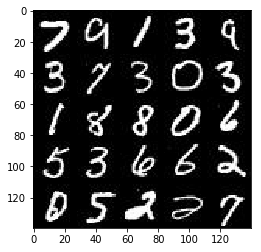

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

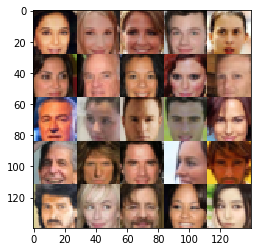

In [3]:
show_n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape = ([None, image_width, image_height, image_channels]), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape = ([None, z_dim]), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, (5,5), strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, (5,5), strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5,5), strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          show_every=100, print_every=15):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Create the model inputs
    real_inputs, fake_inputs, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Get losses for the generator & the discriminator
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    
    # Get optimizers for the generator & the discriminator
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    losses = []
    n_img_show = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, fake_inputs: batch_z, lr_tensor: learning_rate})
                
                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        
        show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        print("Last train discriminator Loss: {:.4f}\nLast train generator Loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
                
        return losses        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 14.8878... Generator Loss: 0.0000


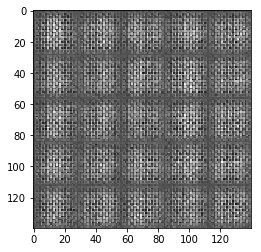

Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 6.8506
Epoch 1/2... Discriminator Loss: 0.0664... Generator Loss: 4.4277
Epoch 1/2... Discriminator Loss: 0.1586... Generator Loss: 3.2778
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.8786


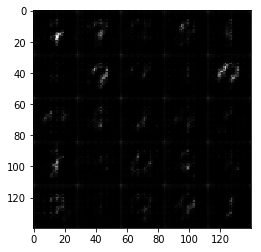

Epoch 1/2... Discriminator Loss: 0.6244... Generator Loss: 3.2639
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 0.0855... Generator Loss: 5.4184
Epoch 1/2... Discriminator Loss: 0.1329... Generator Loss: 2.4445
Epoch 1/2... Discriminator Loss: 0.0242... Generator Loss: 4.9945
Epoch 1/2... Discriminator Loss: 0.0628... Generator Loss: 4.5794
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 1.0598


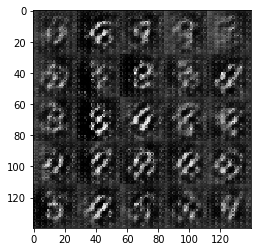

Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 3.4873
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 0.8238... Generator Loss: 1.1741
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 0.6666


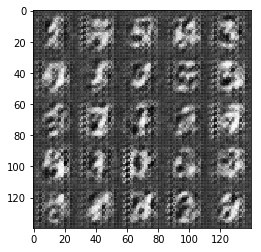

Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.0685
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 2.9177
Epoch 1/2... Discriminator Loss: 0.1139... Generator Loss: 3.2967
Epoch 1/2... Discriminator Loss: 0.1250... Generator Loss: 2.8041


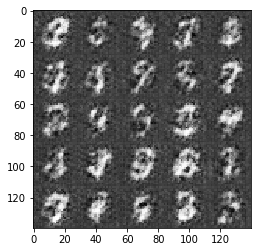

Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 2.8895
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 0.0421... Generator Loss: 4.0300
Epoch 1/2... Discriminator Loss: 0.0345... Generator Loss: 4.4836


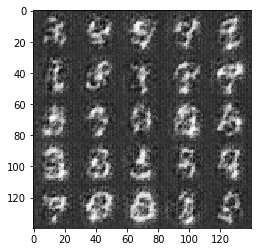

Epoch 1/2... Discriminator Loss: 0.1444... Generator Loss: 2.4576
Epoch 1/2... Discriminator Loss: 0.3154... Generator Loss: 1.5178
Epoch 1/2... Discriminator Loss: 0.0807... Generator Loss: 3.0029
Epoch 1/2... Discriminator Loss: 0.0293... Generator Loss: 5.4171
Epoch 1/2... Discriminator Loss: 2.2038... Generator Loss: 0.2249
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.8294


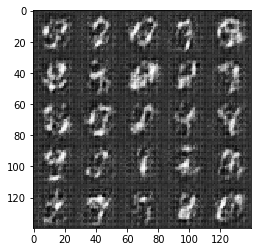

Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.7854
Epoch 1/2... Discriminator Loss: 3.0267... Generator Loss: 5.2764
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 1.9409
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 2.6446
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 1.6837


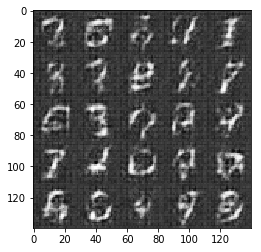

Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 1.9790
Epoch 1/2... Discriminator Loss: 0.2476... Generator Loss: 2.2187
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 1.4548
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.1231
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.0597
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 2.9335


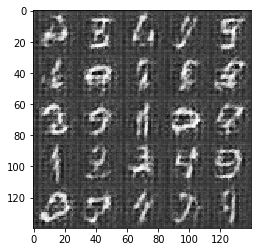

Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 1.6952
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 2.3387
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 2.9802
Epoch 1/2... Discriminator Loss: 0.5599... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 0.2119... Generator Loss: 1.9988
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 1.2628
Epoch 1/2... Discriminator Loss: 0.0677... Generator Loss: 3.3464


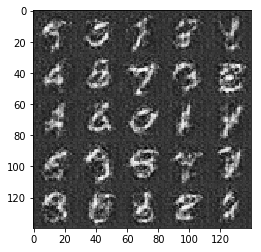

Epoch 1/2... Discriminator Loss: 0.1245... Generator Loss: 2.5200
Epoch 1/2... Discriminator Loss: 0.0642... Generator Loss: 3.4368
Epoch 1/2... Discriminator Loss: 0.0439... Generator Loss: 3.8010
Epoch 1/2... Discriminator Loss: 0.0282... Generator Loss: 4.5681
Epoch 1/2... Discriminator Loss: 0.0172... Generator Loss: 4.9210
Epoch 1/2... Discriminator Loss: 0.0578... Generator Loss: 3.2745


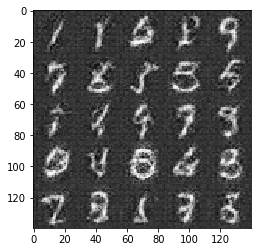

Epoch 1/2... Discriminator Loss: 0.0294... Generator Loss: 4.3798
Epoch 1/2... Discriminator Loss: 0.0122... Generator Loss: 6.2682
Epoch 1/2... Discriminator Loss: 0.0099... Generator Loss: 5.5373
Epoch 1/2... Discriminator Loss: 0.0773... Generator Loss: 3.1081
Epoch 1/2... Discriminator Loss: 0.0177... Generator Loss: 4.9615
Epoch 1/2... Discriminator Loss: 0.0077... Generator Loss: 5.7874
Epoch 1/2... Discriminator Loss: 0.0235... Generator Loss: 4.3885


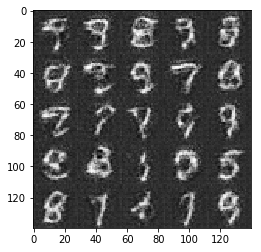

Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 4.9337
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 5.1541
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.4836... Generator Loss: 3.0578


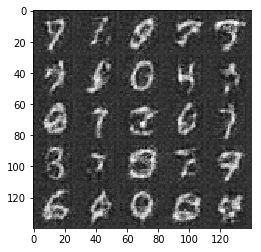

Epoch 1/2... Discriminator Loss: 2.3155... Generator Loss: 0.2872
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 1.3307
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 2.6774
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 0.2820... Generator Loss: 2.3636
Epoch 1/2... Discriminator Loss: 0.2037... Generator Loss: 1.9837


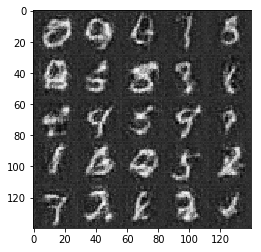

Epoch 1/2... Discriminator Loss: 0.1092... Generator Loss: 2.8372
Epoch 1/2... Discriminator Loss: 0.0337... Generator Loss: 4.1098
Epoch 1/2... Discriminator Loss: 0.2410... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 3.8270
Epoch 1/2... Discriminator Loss: 0.1745... Generator Loss: 2.3127
Epoch 1/2... Discriminator Loss: 0.0558... Generator Loss: 3.3377
Epoch 1/2... Discriminator Loss: 0.0284... Generator Loss: 4.0974


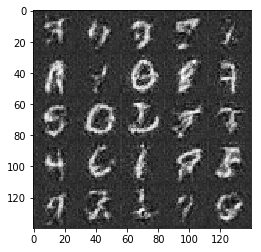

Epoch 1/2... Discriminator Loss: 0.0476... Generator Loss: 3.4540
Epoch 1/2... Discriminator Loss: 0.1170... Generator Loss: 2.6502
Epoch 1/2... Discriminator Loss: 0.0300... Generator Loss: 4.5605
Epoch 1/2... Discriminator Loss: 0.1193... Generator Loss: 2.4544
Epoch 1/2... Discriminator Loss: 0.1310... Generator Loss: 2.5333
Epoch 1/2... Discriminator Loss: 0.0395... Generator Loss: 3.7231
Epoch 1/2... Discriminator Loss: 0.0063... Generator Loss: 6.7862


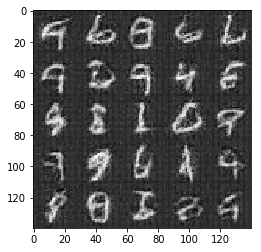

Epoch 1/2... Discriminator Loss: 0.0458... Generator Loss: 3.6267
Epoch 1/2... Discriminator Loss: 0.0159... Generator Loss: 5.5762
Epoch 1/2... Discriminator Loss: 0.0660... Generator Loss: 3.3763
Epoch 1/2... Discriminator Loss: 0.0105... Generator Loss: 7.2645
Epoch 1/2... Discriminator Loss: 0.0619... Generator Loss: 3.3698
Epoch 1/2... Discriminator Loss: 0.0410... Generator Loss: 3.7004


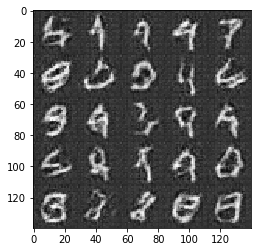

Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 3.0450... Generator Loss: 0.0992
Epoch 1/2... Discriminator Loss: 0.3313... Generator Loss: 1.9271
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 1.6849
Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 2.5758
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 3.2550... Generator Loss: 6.7350


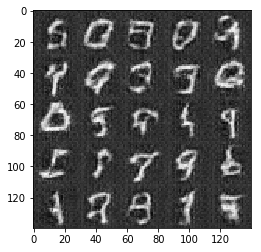

Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.2136... Generator Loss: 2.0398
Epoch 1/2... Discriminator Loss: 0.0645... Generator Loss: 3.3236
Epoch 1/2... Discriminator Loss: 0.3575... Generator Loss: 1.6191
Epoch 1/2... Discriminator Loss: 2.1266... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 1.9870
Epoch 1/2... Discriminator Loss: 0.2147... Generator Loss: 2.0546


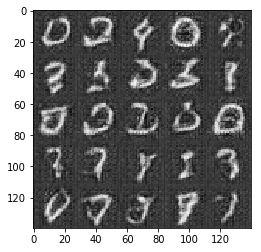

Epoch 1/2... Discriminator Loss: 0.0743... Generator Loss: 3.4728
Epoch 1/2... Discriminator Loss: 0.2342... Generator Loss: 1.8871
Epoch 1/2... Discriminator Loss: 0.0265... Generator Loss: 4.9337
Epoch 1/2... Discriminator Loss: 0.3440... Generator Loss: 1.6204
Epoch 2/2... Discriminator Loss: 0.2168... Generator Loss: 1.9286


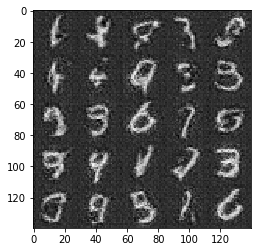

Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 4.3906
Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 2.0304
Epoch 2/2... Discriminator Loss: 0.2823... Generator Loss: 1.9514
Epoch 2/2... Discriminator Loss: 0.3666... Generator Loss: 2.0638
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 5.4151
Epoch 2/2... Discriminator Loss: 1.6502... Generator Loss: 0.3265


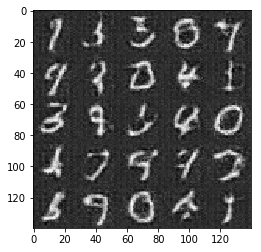

Epoch 2/2... Discriminator Loss: 0.4624... Generator Loss: 1.4552
Epoch 2/2... Discriminator Loss: 0.3469... Generator Loss: 1.6856
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 2.7843
Epoch 2/2... Discriminator Loss: 0.0337... Generator Loss: 4.0110
Epoch 2/2... Discriminator Loss: 0.0226... Generator Loss: 5.0401
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 1.2042


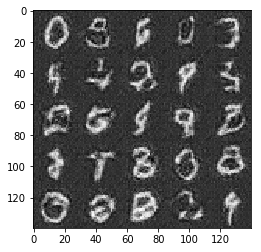

Epoch 2/2... Discriminator Loss: 0.0436... Generator Loss: 3.8162
Epoch 2/2... Discriminator Loss: 0.2395... Generator Loss: 2.0709
Epoch 2/2... Discriminator Loss: 0.1104... Generator Loss: 2.5389
Epoch 2/2... Discriminator Loss: 0.0117... Generator Loss: 6.0805
Epoch 2/2... Discriminator Loss: 0.0153... Generator Loss: 4.8767
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 3.5841
Epoch 2/2... Discriminator Loss: 0.1404... Generator Loss: 2.5012


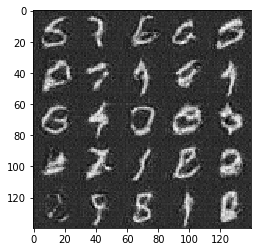

Epoch 2/2... Discriminator Loss: 0.0203... Generator Loss: 4.3728
Epoch 2/2... Discriminator Loss: 0.0713... Generator Loss: 3.3448
Epoch 2/2... Discriminator Loss: 0.0408... Generator Loss: 3.7428
Epoch 2/2... Discriminator Loss: 0.1407... Generator Loss: 2.4054
Epoch 2/2... Discriminator Loss: 0.0238... Generator Loss: 4.2573
Epoch 2/2... Discriminator Loss: 0.0103... Generator Loss: 5.3926


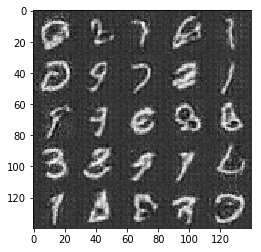

Epoch 2/2... Discriminator Loss: 0.0031... Generator Loss: 6.6160
Epoch 2/2... Discriminator Loss: 0.1046... Generator Loss: 2.8440
Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 3.8149
Epoch 2/2... Discriminator Loss: 0.0078... Generator Loss: 5.3073
Epoch 2/2... Discriminator Loss: 0.0214... Generator Loss: 4.3176
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.7452


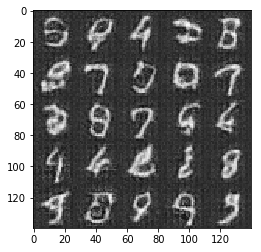

Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 2.2506
Epoch 2/2... Discriminator Loss: 0.2704... Generator Loss: 2.5110
Epoch 2/2... Discriminator Loss: 0.5980... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 0.2695... Generator Loss: 4.0933
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 0.9449


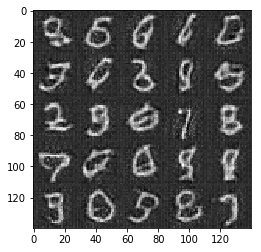

Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 2.7697
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 3.4373
Epoch 2/2... Discriminator Loss: 0.5372... Generator Loss: 1.2126
Epoch 2/2... Discriminator Loss: 0.2790... Generator Loss: 1.8979
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.2688
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 1.9002


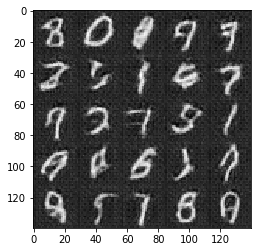

Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 4.6999
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 1.8991
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.0872
Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 1.7829
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.5939
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 3.5611


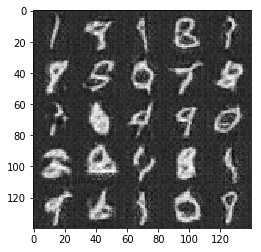

Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.3687
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 1.7003
Epoch 2/2... Discriminator Loss: 0.2437... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 0.1611... Generator Loss: 2.2546
Epoch 2/2... Discriminator Loss: 0.0259... Generator Loss: 5.9116
Epoch 2/2... Discriminator Loss: 0.0529... Generator Loss: 3.4647
Epoch 2/2... Discriminator Loss: 0.0887... Generator Loss: 2.8446


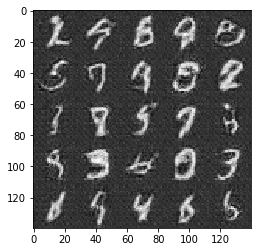

Epoch 2/2... Discriminator Loss: 0.0645... Generator Loss: 3.1021
Epoch 2/2... Discriminator Loss: 0.0604... Generator Loss: 4.1017
Epoch 2/2... Discriminator Loss: 0.2533... Generator Loss: 2.2553
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.2452
Epoch 2/2... Discriminator Loss: 0.1251... Generator Loss: 2.6549
Epoch 2/2... Discriminator Loss: 0.1046... Generator Loss: 2.8236


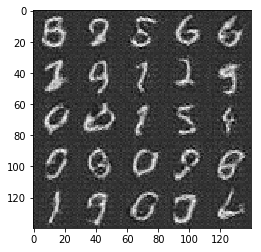

Epoch 2/2... Discriminator Loss: 6.6685... Generator Loss: 0.0037
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 3.4561
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 4.4999
Epoch 2/2... Discriminator Loss: 0.2986... Generator Loss: 2.7156
Epoch 2/2... Discriminator Loss: 0.4506... Generator Loss: 1.4938
Epoch 2/2... Discriminator Loss: 0.2880... Generator Loss: 1.8196


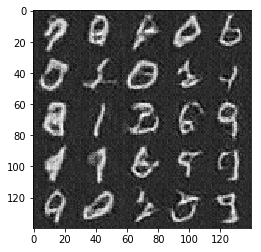

Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 5.3440
Epoch 2/2... Discriminator Loss: 0.1167... Generator Loss: 3.3089
Epoch 2/2... Discriminator Loss: 0.1714... Generator Loss: 2.3901
Epoch 2/2... Discriminator Loss: 0.0765... Generator Loss: 3.2573
Epoch 2/2... Discriminator Loss: 0.0231... Generator Loss: 4.7214
Epoch 2/2... Discriminator Loss: 0.1961... Generator Loss: 2.2249
Epoch 2/2... Discriminator Loss: 0.1306... Generator Loss: 2.7104


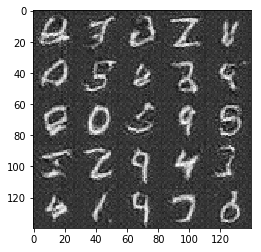

Epoch 2/2... Discriminator Loss: 0.1356... Generator Loss: 2.3999
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 3.2364
Epoch 2/2... Discriminator Loss: 0.0533... Generator Loss: 3.6467
Epoch 2/2... Discriminator Loss: 0.0224... Generator Loss: 4.4309
Epoch 2/2... Discriminator Loss: 0.0166... Generator Loss: 4.9347
Epoch 2/2... Discriminator Loss: 0.1319... Generator Loss: 2.4556


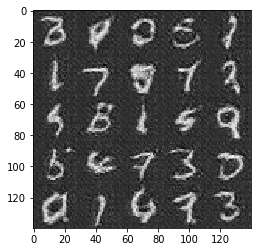

Epoch 2/2... Discriminator Loss: 0.1657... Generator Loss: 2.6195
Epoch 2/2... Discriminator Loss: 0.1198... Generator Loss: 2.6805
Epoch 2/2... Discriminator Loss: 0.0544... Generator Loss: 3.4285
Epoch 2/2... Discriminator Loss: 0.0951... Generator Loss: 2.8330
Epoch 2/2... Discriminator Loss: 0.3737... Generator Loss: 1.5946
Epoch 2/2... Discriminator Loss: 0.0343... Generator Loss: 4.0851
Epoch 2/2... Discriminator Loss: 0.0541... Generator Loss: 3.4765


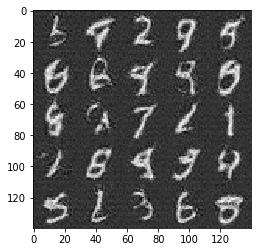

Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 3.8504
Epoch 2/2... Discriminator Loss: 0.0237... Generator Loss: 4.3865
Epoch 2/2... Discriminator Loss: 0.0103... Generator Loss: 5.6739
Epoch 2/2... Discriminator Loss: 0.0086... Generator Loss: 5.8331
Epoch 2/2... Discriminator Loss: 0.0180... Generator Loss: 5.9016
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 3.0895
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 3.1684


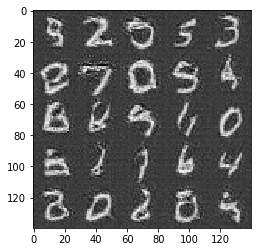

Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 7.4482
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 3.5422
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 5.4624
Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 2.0702
Epoch 2/2... Discriminator Loss: 0.0840... Generator Loss: 2.9575
Epoch 2/2... Discriminator Loss: 0.0140... Generator Loss: 5.4940


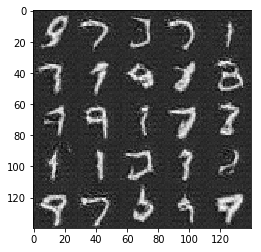

Epoch 2/2... Discriminator Loss: 0.0168... Generator Loss: 4.5799
Epoch 2/2... Discriminator Loss: 0.0043... Generator Loss: 7.0135
Epoch 2/2... Discriminator Loss: 0.0060... Generator Loss: 5.8478
Epoch 2/2... Discriminator Loss: 0.0040... Generator Loss: 6.3845
Epoch 2/2... Discriminator Loss: 0.0040... Generator Loss: 6.3603
Epoch 2/2... Discriminator Loss: 0.0453... Generator Loss: 3.8070
Epoch 2/2... Discriminator Loss: 0.0898... Generator Loss: 2.8024


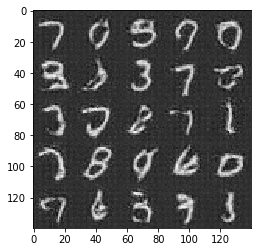

Epoch 2/2... Discriminator Loss: 0.0422... Generator Loss: 3.7594
Epoch 2/2... Discriminator Loss: 0.1354... Generator Loss: 2.7465
Epoch 2/2... Discriminator Loss: 0.0941... Generator Loss: 2.9068
Epoch 2/2... Discriminator Loss: 0.0383... Generator Loss: 4.0608
Epoch 2/2... Discriminator Loss: 1.6062... Generator Loss: 4.3920
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 4.4539
Epoch 2/2... Discriminator Loss: 0.3458... Generator Loss: 2.3509


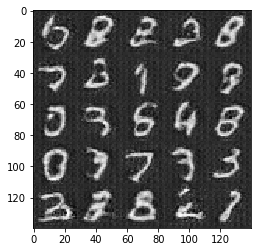

Epoch 2/2... Discriminator Loss: 0.2324... Generator Loss: 3.1020
Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 2.2781
Epoch 2/2... Discriminator Loss: 0.1160... Generator Loss: 4.6863
Epoch 2/2... Discriminator Loss: 0.2168... Generator Loss: 2.5072


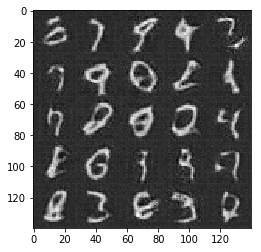

Last train discriminator Loss: 0.2168
Last train generator Loss: 2.5072


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 15.4050... Generator Loss: 0.0000


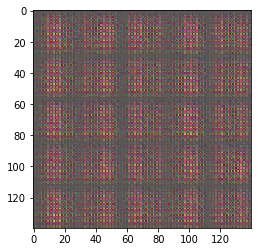

Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.8621
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 4.3485
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 0.2997... Generator Loss: 2.6966
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 4.7086
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 5.2247


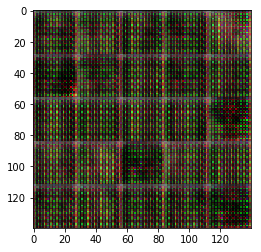

Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 1.7501... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 1.5441


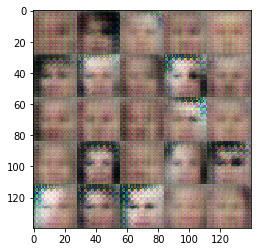

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.8483... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 2.3285... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 2.2511


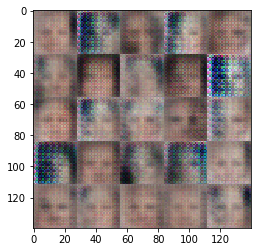

Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 3.7315
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 2.4635
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.0488


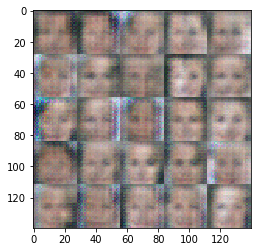

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 3.5191
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.0334
Epoch 1/1... Discriminator Loss: 2.3781... Generator Loss: 0.1112


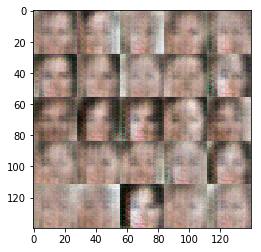

Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 3.5076
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 4.3411
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.5272


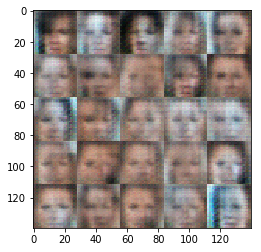

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 3.9592
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 4.0828
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.1255


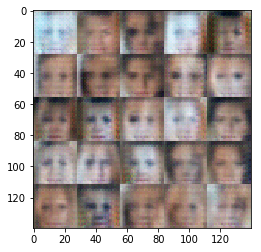

Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: 1.8383... Generator Loss: 4.9487
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 4.4026


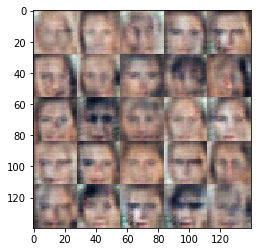

Epoch 1/1... Discriminator Loss: 2.3583... Generator Loss: 0.1287
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 2.9864
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 2.3597
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.1337


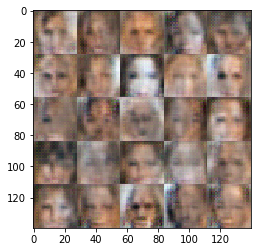

Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 1.6370
Epoch 1/1... Discriminator Loss: 0.2106... Generator Loss: 3.1043
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 2.2573
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 2.0187


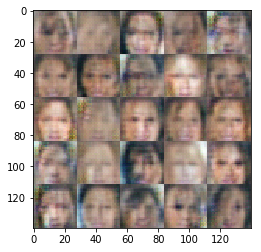

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 4.8878... Generator Loss: 5.9089
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 2.1666
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 2.4481... Generator Loss: 2.7318


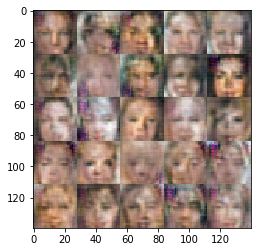

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 1.8679
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.7844
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.5699


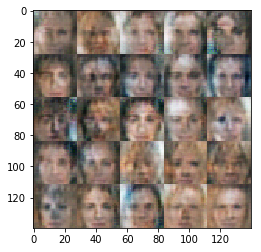

Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.0175


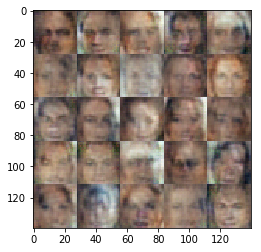

Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 1.8218
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.4060


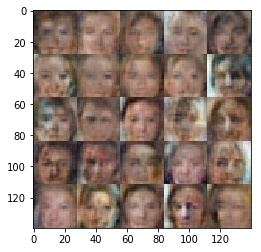

Epoch 1/1... Discriminator Loss: 1.8221... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.8578
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 1.8863
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 1.7946


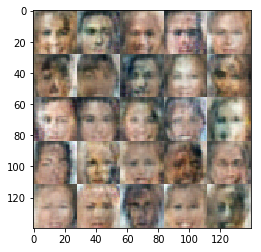

Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.0838
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.0854


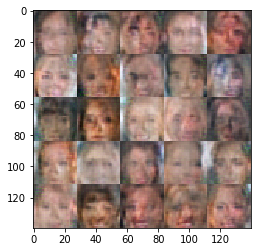

Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 1.8943... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 2.8422


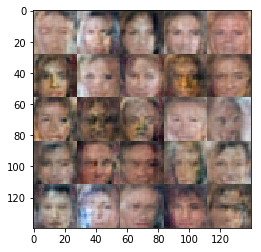

Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.1673
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.8087
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 3.6789


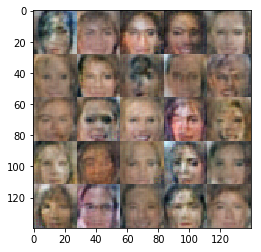

Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.9962


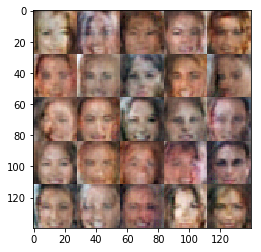

Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.3260
Epoch 1/1... Discriminator Loss: 1.6643... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.3970


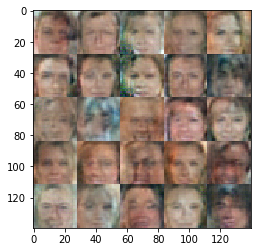

Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 2.2641
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.6195


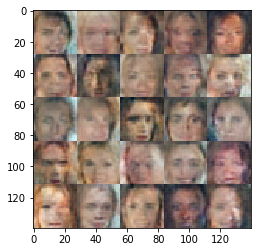

Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 2.8430
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 1.8213... Generator Loss: 0.2411
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 2.2270


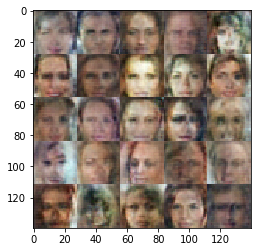

Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.5762


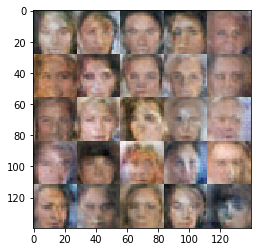

Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 2.5086
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.1331


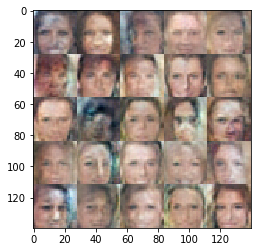

Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.6119
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.4511


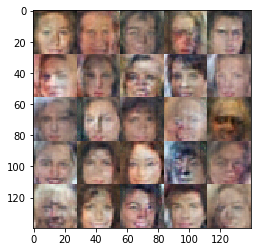

Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 2.3048
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 2.1691... Generator Loss: 0.1852
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.6078


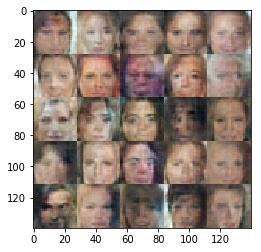

Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 2.4268
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.5196


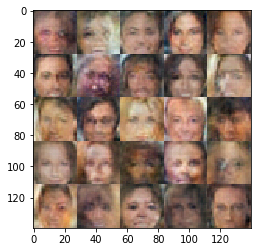

Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.7962... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.8026... Generator Loss: 0.2525


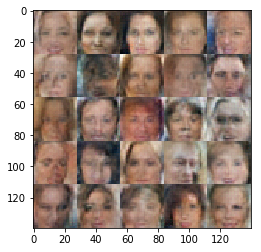

Epoch 1/1... Discriminator Loss: 1.7652... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.5660
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 3.1996
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.3042


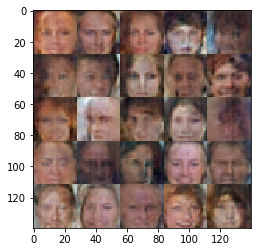

Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.9975
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.2665
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.3685


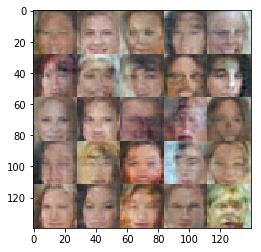

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 2.6882... Generator Loss: 5.2023
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 2.3499
Epoch 1/1... Discriminator Loss: 0.2926... Generator Loss: 3.0442
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 1.8335


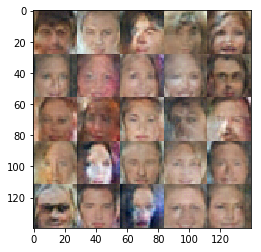

Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 2.3977
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.7249
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.9244


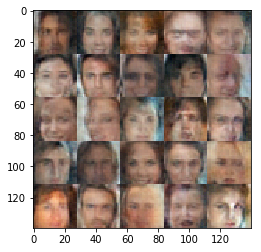

Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.5134


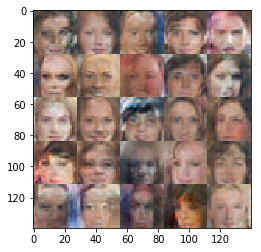

Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.7072


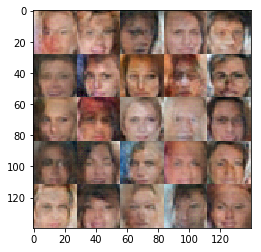

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 2.3795
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.0009
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 1.9350
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.4387


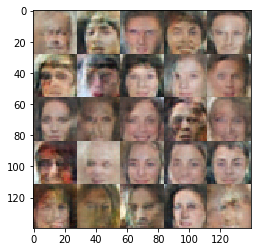

Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.7549


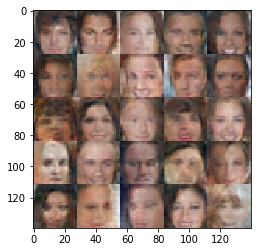

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.3574


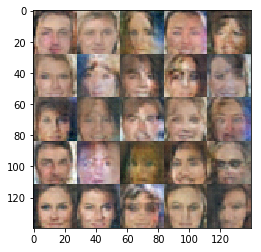

Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.3451
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.2506


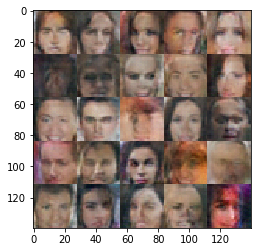

Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.8045
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 1.8143... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.4645


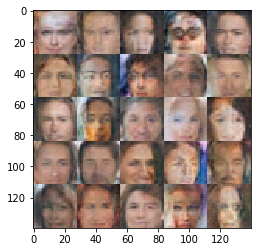

Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.1699
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.5178


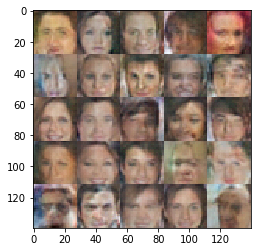

Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 0.9359


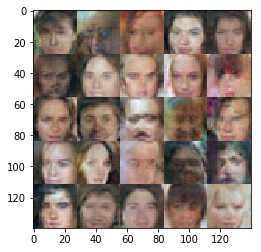

Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 0.9438


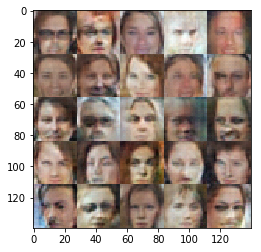

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.5486


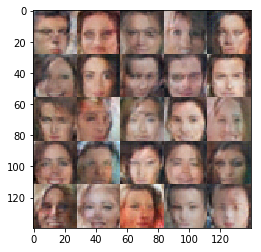

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 3.2852
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.4898


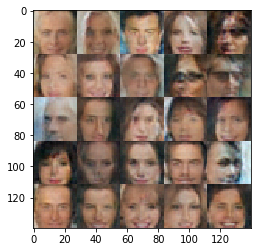

Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.3384


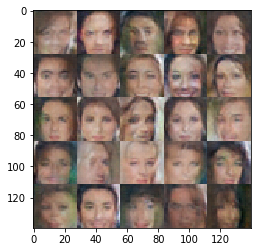

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 2.5116
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.8724
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.5986


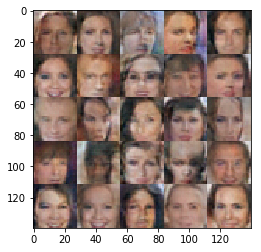

Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 2.0171
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.8926... Generator Loss: 0.2186
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 3.2110
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.2229


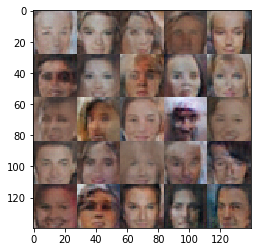

Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.5527


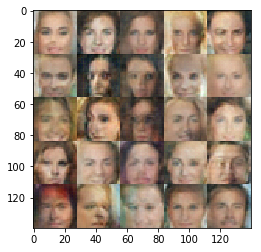

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.7427


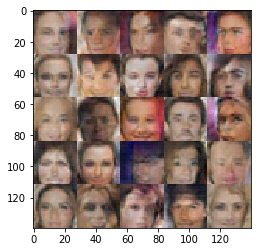

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.7883
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 3.6747


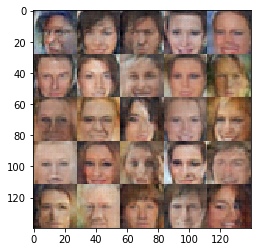

Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 2.5841
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.3564


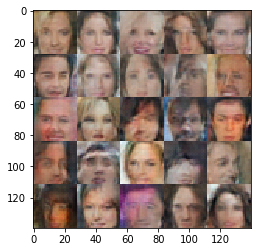

Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 2.5252
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.2150


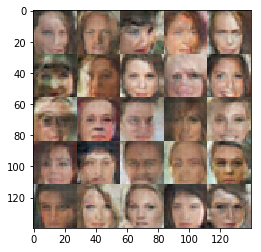

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.5440


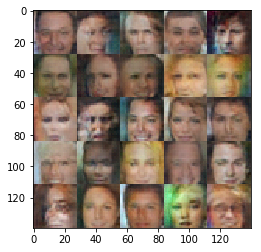

Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6530


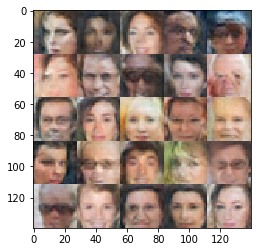

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.6917


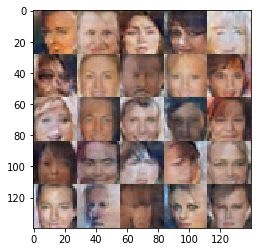

Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 2.4279
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.5339


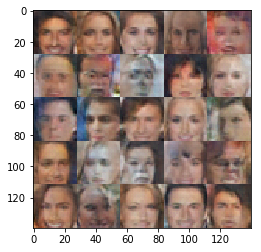

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 2.6029


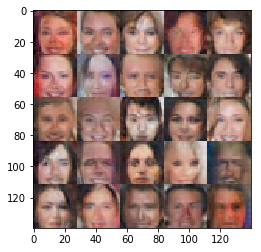

Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.4148


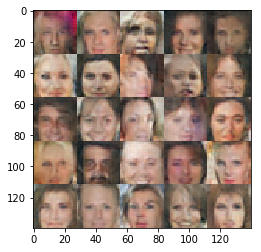

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 2.0686... Generator Loss: 0.2637
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.6697


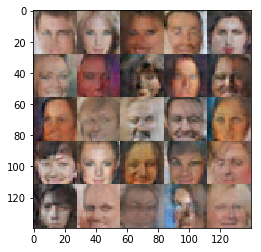

Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.3235
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 1.6405


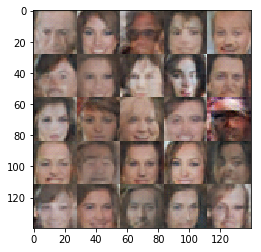

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6525


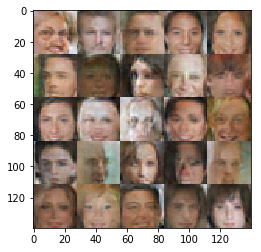

Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.8495... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.5841


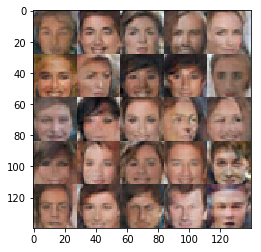

Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.4100
Epoch 1/1... Discriminator Loss: 1.9135... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 2.0381
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.2716


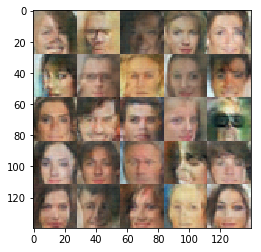

Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.6993


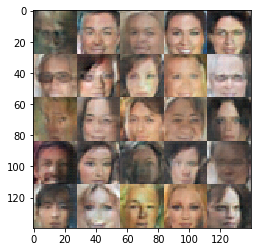

Last train discriminator Loss: 1.0654
Last train generator Loss: 0.6993


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.